In [1]:
import sys
sys.path.append("..")

from system_controller import SystemController
from utils import transform_angle_error, transform_02pi_to_negpospi, Simulator

import numpy as np
import time
import matplotlib.pyplot as plt
from time import perf_counter
from scipy.integrate import odeint

plt.style.use(["science", "grid"])

# Pendulum
Try MPPI controller with a pendulum:
![alternatvie text](http://underactuated.mit.edu/figures/simple_pend.svg)

The state-space representation of the system is $x = (\theta, \dot{\theta})$, $u = \tau$, and the dynamics of the inverted pendulum are given by:
$$
\begin{align*}
    \dot{\theta} &= \dot{\theta} \\
    \ddot{\theta} &= \frac{\tau - mgl\sin(\theta) - b\dot{\theta}}{ml^2}
\end{align*}
$$

### Controller Definition

In [ ]:
from systems.dynamical_systems import Pendulum

pend = Pendulum(m=1, l=1, b=0.1, dt=1 / 10)

DESIRED_THETA = np.pi
DESIRED_OMEGA = 0.0

def terminal_cost(x):
    theta, omega = x
    
    theta_error = np.cos(theta - DESIRED_THETA + np.pi) + 1
    omega_error = DESIRED_OMEGA - omega

    error = np.array([theta_error, omega_error])
    Q = np.diag([10, 1])

    return error.T @ Q @ error

def state_cost(x):
    theta, omega = x
        
    theta_error = transform_angle_error(DESIRED_THETA - theta)
        
    error = np.array([theta_error])
    Q = np.diag([1])

    return error.T @ Q @ error

pend_controller = SystemController(
    ds=pend,
    n_rollouts=100,
    horizon_length=10,
    exploration_cov=np.diag([0.5 ** 2]),
    exploration_lambda=1e-2,
    state_cost=state_cost, terminal_cost=terminal_cost,
    control_range={"min": pend.tau_lo, "max": pend.tau_hi},
    include_null_controls=True
)

In [ ]:
def pend_initial_state_str(initial_state):
    theta, thetadot = initial_state
    return "pendulum_{:.3f}theta_{:.3f}thetadot".format(theta, thetadot)

### Simulation Definition

In [ ]:
INITIAL_STATE = np.array([np.radians(0), 0])

pend_env = Simulator(pend, controller=pend_controller)
states, controls, time = pend_env.run(simulation_length=12, initial_state=INITIAL_STATE, controlled=True)

### Simulation Results

In [ ]:
# Plot the results
fig, axd = plt.subplot_mosaic([['ul', 'r'], ['ll', 'r']], figsize=(9, 4), layout="constrained")

fig.suptitle("Pendulum Swing Up Response")

axd["ul"].plot(time, states[:, 0], label="Theta")
axd["ul"].set(xlabel="Time (s)", ylabel="Theta [rad]")

axd["ll"].plot(time, states[:, 1], label="Angular Velocity")
axd["ll"].set(xlabel="Time (s)", ylabel="Angular Velocity [rad/s]")

axd["r"].plot(time, controls[:, 0])
axd["r"].set(xlabel="Time (s)", ylabel="Torque [Nm]")

plt.tight_layout()
fig.savefig("figs/pendulum_swingup.png")

In [ ]:
s1 = states[:, 1][1:-1]
s2 = np.roll(states[:, 1], 1)[1:-1]
             
accels = (s1-s2)/pend.dt
print(np.min(accels), np.max(accels)),
print(np.sqrt(np.var(accels)))

## Pendulum Control with Inverse Dynamics
Use a linearization technique to have the MPC controller use inputs $u = \ddot{\theta}$, where MPC returns a desired acceleration, $\ddot{\theta}_d$, to be conerted into system input torque $\tau$ as $\tau = f(\ddot{\theta}_d)$, where the function $f$ for a pendulum is defined as its inverse dynamics:
$$
f(\ddot{\theta}_d) = \tau_d = \ddot{\theta}_d m l^2 + b\dot{\theta} + mgl\sin(\theta)
$$

In [ ]:
alpha_mag = np.array([2])

pend = Pendulum(m=1, l=1, b=0.1, dt=1 / 20)
pend_controller = SystemController(
    ds=pend,
    n_rollouts=150,
    horizon_length=12,
    exploration_cov=np.diag([1 ** 2]),
    exploration_lambda=1e-6,
    state_cost=state_cost, terminal_cost=terminal_cost,
    control_range={"min": -alpha_mag, "max": alpha_mag},
    include_null_controls=True,
    inverse_dyn_control=True
)

In [ ]:
INITIAL_STATE = np.array([np.radians(0), 0])

pend_env = Simulator(pend, controller=pend_controller)
states, controls, time = pend_env.run(simulation_length=5, initial_state=INITIAL_STATE, controlled=True)

In [ ]:
# Plot the results
fig, axd = plt.subplot_mosaic([['ul', 'r'], ['ll', 'r']], figsize=(9, 4), layout="constrained")

fig.suptitle("Pendulum Swing Up Response")

axd["ul"].plot(time, states[:, 0], label="Theta")
axd["ul"].set(xlabel="Time (s)", ylabel="Theta [rad]")

axd["ll"].plot(time, states[:, 1], label="Angular Velocity")
axd["ll"].set(xlabel="Time (s)", ylabel="Angular Velocity [rad/s]")

axd["r"].plot(time, controls[:, 0])
axd["r"].set(xlabel="Time (s)", ylabel="Torque [Nm]")

plt.tight_layout()
fig.savefig("figs/pendulum_swingup_invd.png")

# Cart-Pole
Try MPPI controller with a cart-pole system:

![alternatvie text](http://underactuated.mit.edu/figures/cartpole.svg)

The state-space representation of the system is $x = (x, \dot{x}, \theta, \dot{\theta})$, $u = f_x$, and the dynamics of the inverted pendulum are given by:
$$
\begin{align*}
    \dot{x} &= \dot{x} \\
    \ddot{x} &= \frac{1}{m_c+m_p\sin^2(\theta)} \left( f_x + m_p\sin(\theta) (l\dot{\theta}^2 + g\cos(\theta)) \right) \\
    \dot{\theta} &= \dot{\theta} \\
    \ddot{\theta} &= \frac{1}{l(m_c+m_p\sin^2(\theta))} \left( -f_x\cos(\theta) - m_p l \dot{\theta}^2 \cos(\theta)\sin(\theta) - (m_c + m_p)g\sin(\theta) \right)
\end{align*}
$$

### Controller Definition

In [ ]:
from systems.dynamical_systems import CartPole

cartpole = CartPole(m_pole=1, m_cart=1, l=1, dt=1 / 10)

DESIRED_THETA = np.pi
DESIRED_CARTVEL = 0.0
DESIRED_CARTPOS = 0.0

# Define the controller cost functions

def terminal_cost(x):
    pos, posdot, theta, thetadot = x

    theta_error = np.cos(theta - DESIRED_THETA + np.pi) + 1
    vel_error = DESIRED_CARTVEL - posdot
    pos_error = DESIRED_CARTPOS - pos

    error = np.array([theta_error, vel_error, pos_error])
    Q = np.diag([500, 10, 10])

    return error.T @ Q @ error

def state_cost(x):
    return terminal_cost(x)

cartpole_controller = SystemController(
    ds=cartpole,
    n_rollouts=150,
    horizon_length=10,
    exploration_cov=np.diag([2 ** 2]),
    exploration_lambda=2e-3,
    terminal_cost=terminal_cost,
    state_cost=state_cost,
    control_range={"min": cartpole_env.u_lo, "max": cartpole_env.u_hi},
    include_null_controls=True
).build()

In [ ]:
def cartpole_initial_state_str(initial_state):
    p, pdot, theta, thetadot = initial_state
    return "cartpole_{:.3f}theta_{:.3f}vel".format(theta, pdot)

### Simulation Definition

In [ ]:
INITIAL_STATE = np.array([0.0, 0, np.radians(0), 0])

cartpole_env = Simulator(cartpole, controller=cartpole_controller)
states, controls, time = cartpole_env.run(simulation_length=6, initial_state=INITIAL_STATE, controlled=True)

### Simulation Results

In [ ]:
# Plot the results
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(8, 8.5))

ax1.plot(time, states[:, 0])
ax1.set(ylabel="Position (m)", title="Cart-Pole Swing Up Response")

ax2.plot(time, states[:, 1])
ax2.set(ylabel="Velocity (m/s)")
ax3.plot(time, transform_02pi_to_negpospi(states[:, 2]))
ax3.set(ylabel="Angle (rad)")

ax4.plot(time, states[:, 3])
ax4.set(ylabel="Angular Velocity (rad/s)")

plt.xlabel("Time (s)")
plt.tight_layout()

fig.savefig("figs/cartpole_swingup.png")

# Planar 2R Dynamic Arm
Try MPPI controller with a planar two-link robot arm modeled with its EOMs.

### Controller Definition

In [153]:
from systems.dynamical_systems import Planar2RArm

M1 = M2 = 2.5
L1 = L2 = 1
R1 = R2 = L1 / 2
I1 = I2 = 1/3 * M1 * L1**2

arm = Planar2RArm(
    m1=M1, m2=M2, l1=L1, l2=L2, r1=R1, r2=R2, I1=I1, I2=I2, dt=1/15
)

DESIRED_POSITION = np.array([0, L1 + L2])
DESIRED_THETAS = np.array([np.pi/2, 0])
TORQUE_STDDEV = 2

# Define the controller cost functions
def terminal_cost(x):
    t1, dot_t1, t2, dot_t2 = x
    
#     thetas = np.array([t1, t2])
#     error = np.cos(DESIRED_THETAS - thetas + np.pi) + 1
#     Q = np.diag([10, 10])
    
    pose = arm.forward_kinematics(t1, t2)
    pos_error = np.linalg.norm(DESIRED_POSITION - pose[:2])
    error = np.array([pos_error])
    Q = np.diag([10])
    
    return np.dot(error, np.dot(Q, error))

def state_cost(x):
    return terminal_cost(x)

arm.u_lo = np.array([-8, -8])
arm.u_hi = -arm.u_lo

arm_controller = SystemController(
    ds=arm,
    n_rollouts=100,
    horizon_length=10,
    exploration_cov=np.diag([TORQUE_STDDEV ** 2, TORQUE_STDDEV ** 2]),
    exploration_lambda=5e-6,
    terminal_cost=terminal_cost,
    state_cost=state_cost,
    control_range={"min": arm.u_lo, "max": arm.u_hi},
    include_null_controls=True
).build()

### Simulation Definition

In [156]:
INITIAL_STATE = np.array([np.radians(-90), 0, 0, 0])

arm_env = Simulator(arm, controller=arm_controller)
states, controls, time = arm_env.run(simulation_length=5, initial_state=INITIAL_STATE, controlled=True)

[Simulator] [Info] planar_2r_arm simulation elapsed time: 5.25477 s


/var/folders/qn/w3_cwyl12lx4j5lszc52_bv40000gn/T/ipykernel_43831/1021417913.py:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


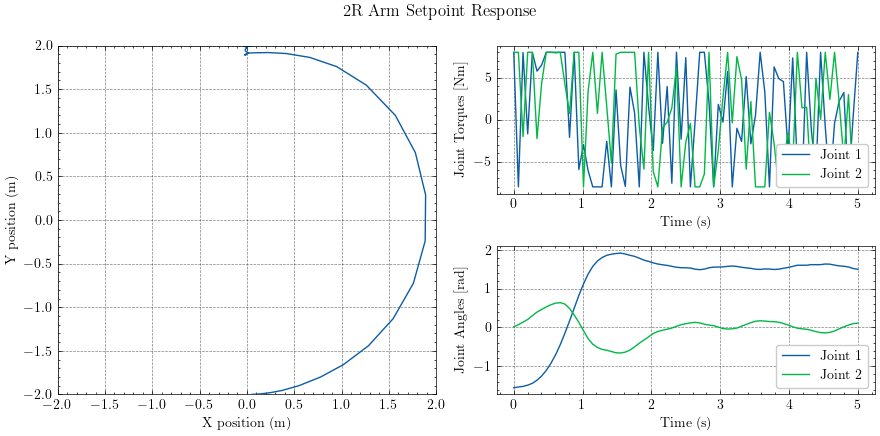

In [157]:
# Plot the results
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8.5), gridspec_kw={'height_ratios': [2.3, 1]})
fig, axd = plt.subplot_mosaic([['p', 't'], ['p', 'ja']], figsize=(9, 4.5), layout="constrained")
fig.suptitle("2R Arm Setpoint Response")

fk = np.vectorize(arm.forward_kinematics, signature="(),()->(3)")

eef_positions = fk(states[:, 0], states[:, 2])

axd['p'].plot(eef_positions[:, 0], eef_positions[:, 1])
axd['p'].set(ylabel="Y position (m)", xlabel="X position (m)", ylim=(-2, 2), xlim=(-2, 2))

axd['t'].plot(time, controls[:, 0], label="Joint 1")
axd['t'].plot(time, controls[:, 1], label="Joint 2")

axd['t'].set(xlabel="Time (s)", ylabel="Joint Torques [Nm]")
axd['t'].legend(loc="lower right")

axd['ja'].plot(time, transform_02pi_to_negpospi(states[:, 0]), label="Joint 1")
axd['ja'].plot(time, transform_02pi_to_negpospi(states[:, 2]), label="Joint 2")

axd['ja'].set(xlabel="Time (s)", ylabel="Joint Angles [rad]")
axd['ja'].legend(loc="lower right")

plt.tight_layout()
fig.savefig("figs/arm_upright.png")